In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Sign Language Digits Dataset
### By [Turkey Ankara Ayrancı Anadolu High School](http://ayrancianadolu.meb.k12.tr) Students

### Link to the dataset: https://github.com/ardamavi/Sign-Language-Digits-Dataset

### Details of datasets:
- Image size: 100 x 100 pixels
- Color space: RGB
- Number of classes: 10 (Digits: 0-9)
- Number of participant students: 218
- Number of samples per student: 10

In [2]:
os.chdir('data/sign_language_dataset')
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [3]:
train_path = 'data/sign_language_dataset/train'
valid_path = 'data/sign_language_dataset/valid'
test_path = 'data/sign_language_dataset/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)\
               .flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [5]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [6]:
x = mobile.layers[-6].output

In [7]:
output = Dense(units=10, activation='softmax')(x)

In [8]:
model = Model(inputs=mobile.input, outputs=output)

In [9]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [10]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [11]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
172/172 - 58s - loss: 0.6342 - accuracy: 0.8224 - val_loss: 0.2936 - val_accuracy: 0.9067
Epoch 2/30
172/172 - 55s - loss: 0.1227 - accuracy: 0.9831 - val_loss: 0.1045 - val_accuracy: 0.9700
Epoch 3/30
172/172 - 56s - loss: 0.0646 - accuracy: 0.9930 - val_loss: 0.0639 - val_accuracy: 0.9800
Epoch 4/30
172/172 - 57s - loss: 0.0395 - accuracy: 0.9953 - val_loss: 0.0448 - val_accuracy: 0.9867
Epoch 5/30
172/172 - 55s - loss: 0.0287 - accuracy: 0.9959 - val_loss: 0.0486 - val_accuracy: 0.9833
Epoch 6/30
172/172 - 56s - loss: 0.0175 - accuracy: 0.9977 - val_loss: 0.0305 - val_accuracy: 0.9900
Epoch 7/30
172/172 - 55s - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0304 - val_accuracy: 0.9900
Epoch 8/30
172/172 - 55s - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9900
Epoch 9/30
172/172 - 55s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 0.9933
Epoch 10/30
172/172 - 55s - loss: 0.0085 - accuracy: 0.9994 - val_loss: 0.0290 - val_accura

In [13]:
test_labels = test_batches.classes

In [14]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [15]:
predictions

array([[9.99927759e-01, 3.48662870e-05, 1.67257099e-07, 9.33783667e-06,
        1.01941259e-05, 5.35942627e-06, 4.91924902e-06, 4.78885966e-07,
        4.83358872e-06, 2.07348126e-06],
       [9.99996662e-01, 1.52041559e-06, 5.04789419e-08, 8.22575004e-08,
        8.68060326e-08, 6.22071568e-08, 1.29858552e-06, 1.16606721e-07,
        4.39648211e-08, 7.72089059e-09],
       [9.99992251e-01, 3.16530668e-06, 4.78593620e-07, 3.70986044e-07,
        9.26830310e-08, 1.18689329e-07, 3.36997346e-07, 9.79671242e-08,
        7.55393842e-07, 2.23088932e-06],
       [9.99948382e-01, 1.70981275e-05, 1.76390786e-05, 3.08483550e-07,
        2.13488329e-06, 4.23350201e-07, 5.79078687e-06, 4.39013007e-07,
        2.99136696e-06, 4.60595538e-06],
       [9.99999166e-01, 1.02634331e-07, 6.82946535e-08, 2.40138593e-08,
        1.22234391e-08, 1.21711821e-07, 3.55190195e-07, 8.92333318e-09,
        1.63961332e-07, 3.41684014e-09],
       [4.55898714e-07, 9.99994159e-01, 3.51486665e-06, 8.59682956e-08,
   

In [16]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


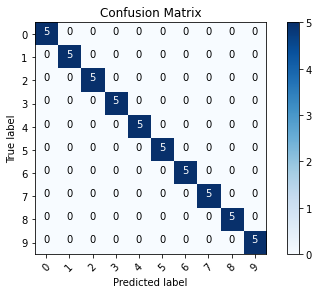

In [19]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')